<a href="https://colab.research.google.com/github/jung-chun/AlbumViewerVNext/blob/master/using_a_simple_rnn_for_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def plot_series(time, series, format = '-', start = 0 , end = None):

  # Setup dimensions of the graph figure
  plt.figure(figsize = (10, 8))

  if type(series) is tuple:

    for series_num in series:

      # Plot the time series data
      plt.plot(time[start: end], series_num[start: end])
  else:
    # Plot the time series data
    plt.plot(time[start: end], series[start: end])

  # Overlay a grid on the graph
  plt.grid(True)

  # Label the x-axis
  plt.xlabel("Time")
  # Label the y-axis
  plt.ylabel("Value")

  # Draw the graph on screen
  plt.show()

def trend(time, slope = 0):

  # Compute the linear series given the slope
  series = time * slope

  return series

def seasonal_pattern(season_time):

  # Generate the values using an arbitrary pattern
  data_pattern = np.where(season_time < 0.4, np.cos(season_time * 3 * np.pi), 1 / np.exp(3 * season_time))

  return data_pattern

def seasonality(time, period, amplitude = 1, phase = 0):

  # Define the measured values per period
  season_time = ((time + phase) % period) /  period

  # Generates the seasonal data scaled by the defined amplitude
  data_pattern = amplitude * seasonal_pattern(season_time)

  return data_pattern

def noise(time, noise_level, seed = None):

  # Initialize the random number generater
  rnd = np.random.RandomState(seed)
  # Generate a random number for each time step and scale by the noise level
  noise = rnd.randn(len(time)) * noise_level

  return noise


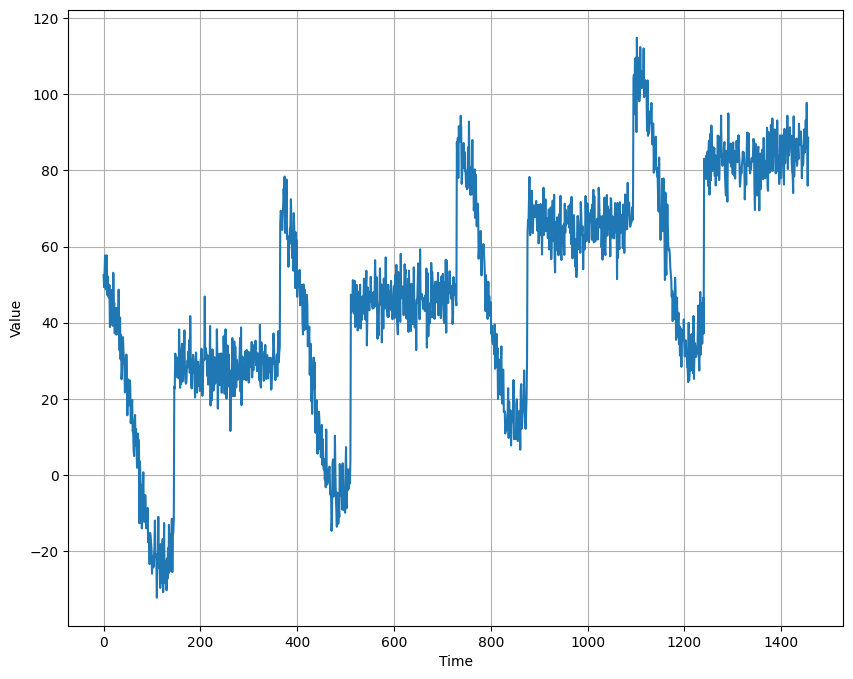

In [11]:
# Parameters
time = np.arange(364 * 4 + 1, dtype = 'float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
series += noise(time, noise_level, seed = 42)

# Plot the results
plot_series(time, series)


In [12]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [13]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In [18]:
# Generates dataset windows
def windowed_dataset(series, wondow_size, batch_size, shuffle_buffer):

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Create tuples with features and labels
  dataset = dataset.map(lambda window: (window[: -1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset


In [19]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [20]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f"shape of feature: {window[0].shape}")
  print(f"shpae of label: {window[1].shape}")

shape of feature: (32, 20)
shpae of label: (32,)


In [55]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences = True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_13 (Lambda)          (None, 20, 1)             0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 20, 40)            1680      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
 lambda_14 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model_tune.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer
)

# Train the model
history = model_tune.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 11ms/step - loss: 62.5154 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 59.7116 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 56.3248 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 52.5355 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 48.3118 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 43.5868 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 15ms/step - loss: 38.3401 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 15ms/step - loss: 32.4972 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 26.0707 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 19.7660 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 50.0)

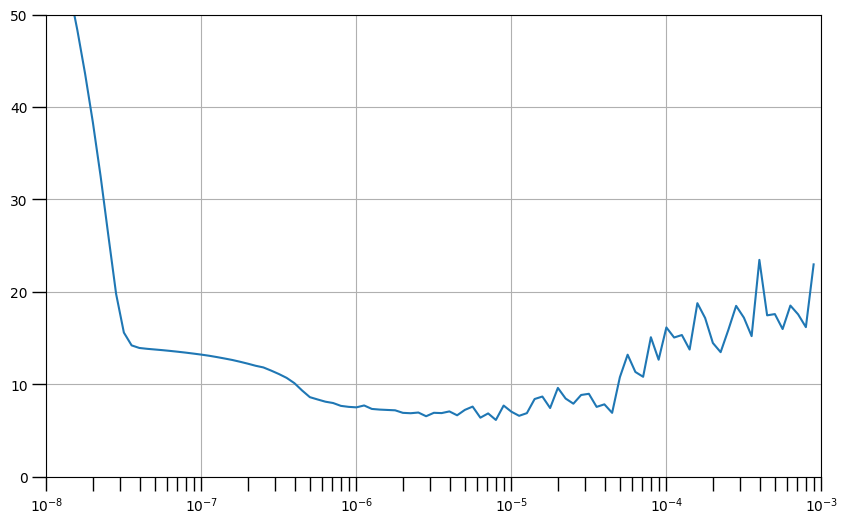

In [62]:
# Define the learning rate array
lrs = 1e-8 * 10**(np.arange(100) / 20)

# Set the figure size
plt.figure(figsize = (10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history['loss'])

# Increase the tickmarks size
plt.tick_params('both', length = 10, width = 1, which = 'both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

(1e-07, 0.0001, 0.0, 50.0)

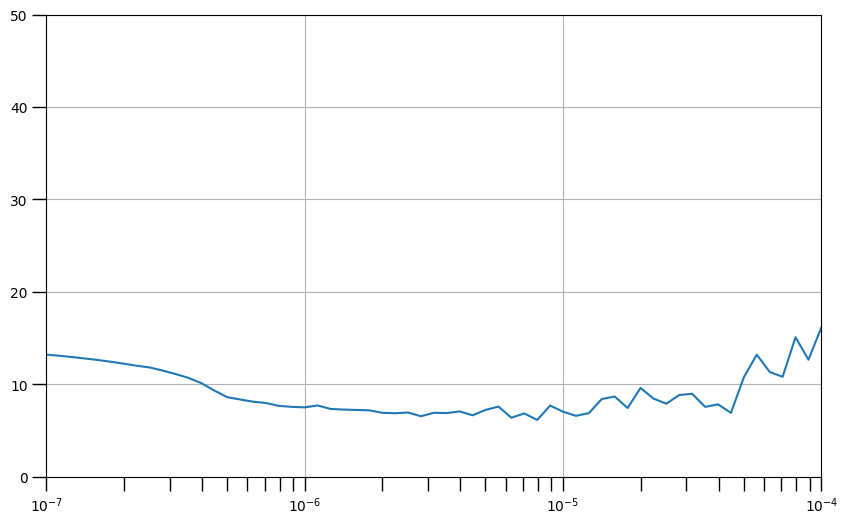

In [58]:
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history['loss'])
plt.tick_params('both', length = 10, width = 1, which = 'both')
plt.axis([1e-7, 1e-4, 0, 50])

In [36]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [window_size]),
    tf.keras.layers.SimpleRNN(40, return_sequences = True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [42]:
learning_rate = 1e-5

optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae']
)

history = model.fit(dataset, epochs = 100, verbose = 0)


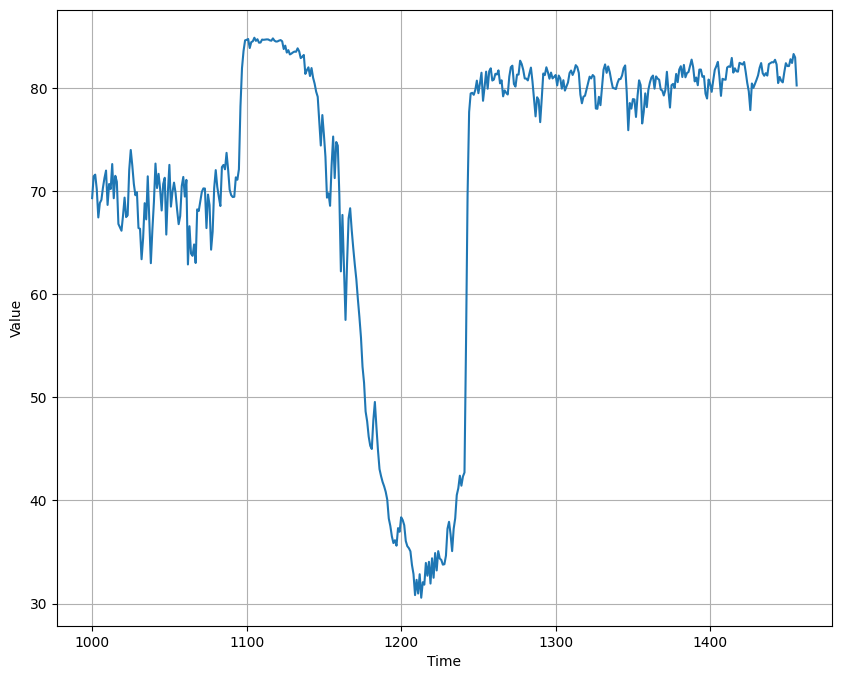

In [43]:
# Prediction
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time: time + window_size][np.newaxis], verbose = 0))

results = np.array(forecast).squeeze()

plot_series(time_valid, results)

In [64]:
def model_forecast(model, series, window_size, batch_size):

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those those with the spectified size
  dataset = dataset.window(window_size, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size))

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  # Get predictions on the entire dataset
  forecast = model.predict(dataset)

  return forecast


15/15 [==============================] - 0s 7ms/step


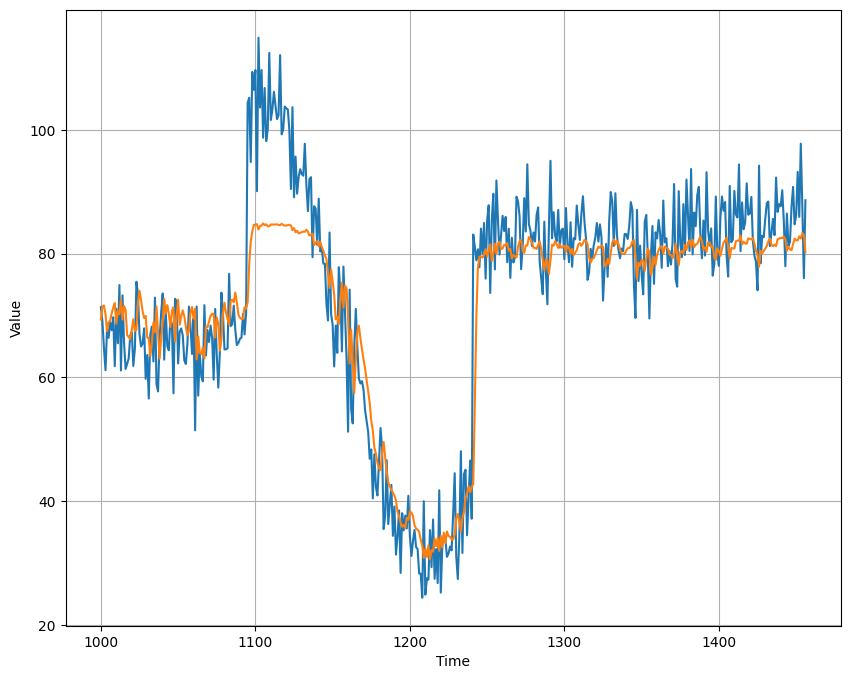

In [63]:
# Reduce the original series
forecast_series = series[split_time - window_size: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))




In [52]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

67.98644
6.1075587
